# Section 05: mixed feelings

Hope Merens (2020), adapted from Angel Tang, Verena Volf and Joseph Sedlak's notes from the past years. 


In [1]:
import numpy as np
import math
import pandas as pd
import scipy.spatial.distance as dis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.random as rand
import scipy.stats as stats
import scipy.misc as misc
from collections import Counter

## Part 1: K-Means

### The Problem

How can we computationally classify single objects together, based on their similarity to each other? In molecular biology and genetics research, it is very common to try to classify cell subtypes, such as neuronal subtypes or cancer cell subtypes in a heterogeneous tumor, based on their transcriptome. For instance, we may assume that varying expression levels of a few genes define the cell subtypes we are interested in. But if we don't know what those expression levels are, how can we group together cells with similar expression levels into the correct subtypes? 

Today, we will use expectation-maximization in order to conduct 1) k-means clustering and 2) mixture modeling as approaches to clustering similar data points together. In the p-set this week, we will see how the same logic can be applied to clustering together cells by their gene expression. 

### Overview of k-means clustering algorithm

The task is to assign $X_i$ (data points or observations) to a predefined number ($k$) of clusters. The k-means clustering algorithm takes an iterative process to assign points to clusters such that the total squared distance between the points and the centroid of their assigned cluster is minimized. The number of clusters $k$ has to be specified by user. 

We start with some randomly chosen centroids $\mu_k$. Then, the two steps - assignment and update - repeated unitl convergence.

**Assignment:** Assign each data point $X_i$ to its closest centroid $μ_k$.

**Update**: Calculate new centroids $\mu_k$ based on newly assigned clusters.

Convergence occurs when the assignments stop changing.

**A note about empty clusters**

It is possible to have empty clusters: centroids that don't have any points assigned. One way to avoid this is to pull one data point out of another cluster and assign it to the empty cluster. There are other ways of doing this as well (e.g. generate another random point) and you can decide what works best for your homework.

**A note on avoiding local minima**

k means clustering is prone to local minima, and it's therefore important to consider your choice of initial conditions. One way to address this problem is to run the algorithm multiple times with different initial centroids and select the best solution out of those runs. Initial centroids can be generated by choosing random coordinates within the range of interest, by selecting the coordinates of existing data points or in other ways.

### Let's implement a 1-dimensional example

We will first generate some clusters of data points with the following features: 
- The number of clusters: 5 
- Means: 3, 10, 17, 24, and 30
- The number of points in each cluster: random between 35 and 45
- Distribution of each cluster: a normal distribution with a random standard deviation between 0 and 1.5

In [2]:
np.random.seed(817)
coords = []
means = [3,10,17,24,31]
real_clusters = []

#generate data points:
for i, x in enumerate(means):
    size = np.random.randint(35, 45)
    coords.extend(list(np.random.normal(x,np.random.random(1)*1.5, size)))
    real_clusters.extend([i]*size)

Take a look at the data points we just generated:

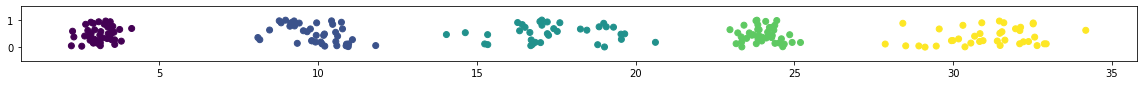

In [3]:
# Quick dot plot to visualize the points
# Give the data points a random y value just for aesthetics
f = plt.figure(figsize = (20,1))
y = rand.rand(len(coords)) # generate some random Ys just for visualization
plt.scatter(coords,y,marker = 'o', c=real_clusters)
plt.ylim(-0.5,1.5)
plt.show()

***Question: Do you think k-means will work for this scenario? What are the assumptions of k-means? Are they violated here?***

In [4]:
# you can write your answer here and check the lecture notes if you're unsure


#### 1) K-means assignment step
$k$ clusters are created by assigning each data point $X_i$ to the nearest centroid $\mu_k$ based on their Euclidian distance in z dimensions $\sqrt{\sum_{z} (X_{iz}-\mu_{kz})^2}$, which is $\sqrt{(X_{i}-\mu_{k})^{2}}$ in this case of 1-dimensional points.

In [5]:
def assignment(coords, centers):  
      
    # Assign each point to the closest center, identifying the closest center using the function argmin
    # Notice that we loop through all the clusters (i in centers) as well as all the data points (point in coords)
    clusters =  [np.argmin([math.sqrt((point-i)**2) for i in centers]) for point in coords]
    
    # record the distance between a point and its closest center
    distances = [np.min([math.sqrt((point-i)**2) for i in centers]) for point in coords]
    
    # Count how many points in each cluster
    c = Counter(clusters)
    
    # Look for empty clusters, assign empty clusters using the assign_empty function (described below)
    for x in set(range(len(centers))).difference(set(c.keys())):
        clusters, distances =  assign_empty(x, clusters, distances)
        
    # calculate the total squared distance
    distance = sum(distances)
    
    return clusters, distance

Taking care of empty clusters:

In [6]:
def assign_empty(c, clusters, distances):
    #The general approach will be to take the data point farthest from any of the current clusters and then assign that point
    #to a new cluster that will replace the empty cluster.
    #Hopefully, this new cluster will better capture the distribution of our data points!
    
    # find index of point furthest from its assigned center
    max_idx = np.argmax(distances)
    
    # set distances at that index to 0
    distances[max_idx] = 0
    
    # set clusters at that index to empty cluster
    clusters[max_idx] = c
    
    return clusters, distances

#### 2) K-means update step
The centroid of the clusters are updated by calculating the mean of all points assigned to that cluster using $\mu_{kz}=\frac{\sum_{i\in{C_k}} X_{iz}}{|C_k|}$.  
For 1-dimensional centers, $\mu_{k}=\frac{\sum_{i\in{C_k}} X_{i}}{|C_k|}$

In [7]:
def update(coords, clusters, num_clust):
    
    coords = np.asarray(coords)
    
    # Find indices of each point assigned to each cluster
    clusters = ([np.where(np.asarray(clusters) == x) for x in range(num_clust)])
    
    # Average position of each point assigned to each cluster to get the updated centroids
    centers = [np.mean(coords[clusters[x]],0) for x in range(len(clusters))]    
    
    return centers

In [8]:
# a helper function for visualization
def plot_centers(centers,c,lw):
    
    for center in centers:            
            plt.axvline(x = center,color = c,linewidth = lw)

Now we'll do the actual iterations.

In [9]:
# Define number of times we will run the k-means algorithm:
# because K-means gives local minima, we need to run the process many times,
# starting with different initial centroids to get a "global minimum"
n_runs = 20
num_clust = 5 # number of clusters

# Initalize best clusters, which can compare at the end of every run
min_dist = float('inf')
clusters_best = []

for i in range(n_runs):
    
    # Each run starts with a random set of centers
    # randomly generate evenly distributed center
    centers = np.random.choice(np.linspace(min(coords), max(coords), 1000), num_clust)
    
    # Start with empty clusters
    clusters_old = []*len(coords)
    clusters = [0]* len(coords)
   
    
    # Iterate until clusters don't change
    while clusters != clusters_old:
        
        # Update clusters
        clusters_old = clusters
        
        #Expectation Step
        # New Assignment 
        clusters,distance = assignment(coords, centers)        
        
        #Maximization Step
        # New centers
        centers = update(coords, clusters, num_clust)
    
    # Save clusters and centers if it has minimal sum distance to date
    if distance < min_dist:            
        min_dist = distance
        centers_best = centers
        clusters_best = clusters 

Let's see if our k-means algorithm works:

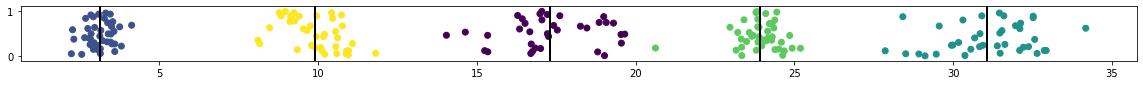

[3, 10, 17, 24, 31]
[ 3.1  9.9 17.3 23.9 31.1]
146.0


In [10]:
# Initialize new figure
plt.close('all')
f = plt.figure(figsize = (20, 1))
plt.scatter(coords, y, marker = 'o', c = clusters_best) # Plot raw data, colored by cluster

# Plot best centroids (means)
plot_centers(centers_best, 'k', 2)

plt.show()

print(means)
print(np.round(sorted(centers_best), 1))
clusters_final, distance_final = assignment(coords, centers_best) 
print(np.round(distance_final))

## Part 2: Mixture Models

A mixture model is a generative probability model composed of other probability distributions. The idea is that our data are generated from a combinations of underlying probability distributions (one per cluster in our case). They don't all have to be the same distribution; they don't even have to be the same type of distribution (you can mix distributions any way you want). In this case, we are going to assume all our points were generated from 1 of Q different Gaussian distribtions with parameters $\mu$ and $\sigma$. Since we are working with multiple Gaussian distributions, we need to add one more parameter, $\pi$, the mixing coefficient that is our best guess as to what fraction of the data was generated by each Gaussian.

We aim to optimize the parameters $\mu$ and $\pi$ and can choose arbitrary initial parameters. Similar to the p-set (in which we use a negative binomial distribution instead of the Gaussian), our choice of sigma will be the same through every iteration. 

There are two steps:

#### 1) Expectation step: 
We want to answer the question of how probable it is that each $X_{i}$ belongs to a cluster $q$, given the data $X_{i}$. We can write this as $P(q|X_{i})$, with the general structure $P(hypothesis|data)$. Look familiar? We can solve for $P(q|X_{i})$ through use of Bayes theorem, where we can calculate $P(X_{i}|q)$ directly for each cluster. 

In other words, for each point $X_{i}$, we calculate a posterior probability  $q$, given our current model with estimates of $\mu$, $\pi$, and our set $\sigma$:  $P(q|X_{i}\pi,\mu,\sigma)$. 

The posterior probability that we want to solve is $P(q \mid X,\mu,\sigma,\pi)$. The relative proportions of the components $\pi$  are unknown. The posterior probability we are trying to solve during the Expectiation step in this problem set is ultimately derived from the marginalization of hidden variables in a joint probability. In this case: $P(q \mid X,\mu,\sigma,\pi) = \frac{P(X,q \mid \mu,\sigma,\pi)}{\Sigma_{q}P(X,q \mid \mu,\sigma,\pi)}$. Conveniently, this joint probability also factors, since the selection of a component from the group of components is independent from the selelection of data point from the component. Therefore, $P(X,q \mid \mu,\sigma,\pi) = P(X \mid q,\mu,\sigma)P(q \mid \pi)$. 

Luckily, these components are easily solvable on their own. The first is simply the likelihood of the data given a particular component. In this example, the components are all Gaussian, so $P(X \mid q,\mu,\sigma) = \frac{1}{\sqrt{2\sigma^{2}\pi}}e^{-\frac{(X-\mu)^{2}}{2\sigma^{2}}}$, i.e. the Gaussian PDF evaulauted at $X$ with $\sigma$ and $\mu$ from the given component $q$ ($\pi$ in that equation is number $\pi$ not the mixture coefficient $\pi$). Note that if $X_{i}$ had components $X_{ia}$ and $X_{ib}$, these can be assumed to be independent. Therefore, $P(X \mid q,\mu,\sigma)$ can be calculated separately for each component, and then the joint probability $P(X_{ia})*P(X_{ib})$ can be calculated.

The $P(q \mid \pi)$ is even easier. It's just $\pi$ (the mixture coefficient $\pi$ not the number $\pi$). Recall that $\pi$ is defined as the fraction of the total data $X$ was generated by each Gaussian. 

Together then, the equation for the posterior probability, generalized for any form of $q$, becomes $P(q \mid X,\mu,\sigma,\pi) = \frac{\pi P(X \mid q,\mu,\sigma)}{\Sigma_{q}\pi P(X \mid q,\mu,\sigma)}$.

#### 2) Maximization step:
We calculate updated 1) centroids $μ_k$ and 2) mixture coefficients $π_q$ given the posterior probabilities $P(q∣X_i,μ,σ,π)$.

1) Centroids $μ_q$ = $\frac{\Sigma_{i} P(q \mid X_{i}) X_{i} }{\Sigma_{i} P(q \mid X_{i})}$

2) Mixture coefficients $π_q$ = $\frac{\Sigma_{i} P(q \mid X_{i})}{N}$, where N represents the number of data points $X_{i}$.

We can follow the total negative log likelihood $\log P(X∣θ)$ through our iterations and stop once the decrease in consecutive nlls falls below a threshold value. 

### We will again implement a 1-dimensional example
We will do this as an exercise - the code for each function is partially given and you will need to translate the pseudocode marked in single quotes (") to actual code. 

#### 1) Expectation
During this step, we calculate the posterior probability for each data point $x$ coming from each component $q$, which is given by $P(q∣x)=\frac{π_qP(x∣θ_q)}{\sum_{q′}π_{q′}P(x∣θ_{q′})}$.

We will also assign each point to a cluster for which it has the largest posterior probability.

In [11]:
# translate the pseudocode marked in '' to actual code
def expectation(coords, mus, sigma, mix_coeffs):
    '''
    Return the Posterior Probability of each data point coming from each component 
    and current cluster assignment for each point
    
    Parameters
    ----------
    coords       : list or1D array, list X-coordinates of all points
    mus            : list or 1D array, list of current estimates for component means
    sigma         : float, set parameter for component variance
    mix_coeffs: list or 1D array, list of current extiamtes for mixture coefficients of components
    
    Returns
    -------
    posts     : 2D array, Posterior probabilities of each component being the source of each point.
    clusters : list or 1D array, list of current cluster assignment for each point 
    '''
    
    # Initialize P(q|x)
    Pqx = []
    
    # Loop through points
    for point in coords: 
        # Append the probability that the point is generated by each component: pi * P(x|θ_q) = pi * P(x|q, 𝜇, σ)
        # (gaussian pdf for x with σ and 𝜇 from component q): you can obtain this using stats.norm.pdf
        'Pqx.append([π*(gaussian pdf for x with σ and μ from component q) for μ in component means])'
        
    # Normalize to obtain the posterior probability that each data point comes from each component
    'posts = [(x divided by sum of all x) for each point x in Pqx]'
    
    # Assign clusters based on max posterior probability
    'clusters = [(index for the largest posterior p) for posterior p in posts]'
    
    return posts, clusters

#### 2) Maximization
During this step, we update the centroids $\mu$ and mixture coefficient $\pi$ given the posterior probabilities.

The new centroid for each component $q$ is calculated as the posterior weighted average of point positions, given by $\mu_q=\frac{\sum_iP(q∣X_i)X_i}{\sum_iP(q∣X_i)}$.

The new mixture coefficient for each component is calculated as the mean of the posteriors for that component, given by $\hat\pi_q=\frac{\sum_iP(q∣X_i)}{N}$.

In [12]:
# translate the pseudocode marked in '' to actual code
def maximization(coords, posts, mix_coeffs):
    '''
    Return the updated mu and mixture coefficient for each component
    
    Parameters
    ----------
    coords       : list or1D array, list X-coordinates of all points
    posts          : 2D array, Posterior probabilities of each component being the source of each point
    mix_coeffs: list or 1D array, list of current extiamtes for mixture coefficients of components
    
    Returns
    -------
    mus           : list or 1D array, current estimate of component means
    mix_coeffs: list or 1D array, updated list of extimates for mixture coefficients of components 
    '''
    
    # calculate the new mean for each component q as the posterior weighted average of point positions 
    # note that each column represents a component in our matrix of posterior probabilities (posts)
    
    # we can first calculate the numerator
    'num_mu = sum of each column([(posterior probs of x)*x for point x in coords)])'
    # now we'll calculate the denominator
    'denom_mu = sum of each column(posts)'
    # divide the numerator by denominator to get the weighted means
    'mus = num_mu / denom_mu'
    
    # calculate the new mixture coefficients as the mean of the posteriors
    # remember that the updated mixture coefficients π are the expected fraction of data points assigned to each component
    'mix_coeffs = sum of each column(posts) / the number of points N'
    
    return mus, mix_coeffs

#### Calculating the log-likelihood of a model
The likelihood of a model is defined as the probability that the observations are generated from the model. We can therefore use log-likelihood to compare the models and choose the one that has the highest likelihood - that is, the smallest negative log-likelihood.

The likelihood of a model is given by: $P(X∣θ)=\prod_i\sum_qπ_qP(X_i∣θ_q)$

The log likelihood is therefore given by: $\log P(X|θ)=\sum_i\log(\sum_qπ_qP(X_i|θ_q))=\sum_i{\rm logSumExp}_q(\logπ_q+\log{P(X_i|θ_q)})$. 

The last equation here is less intuitive, but using log probabilities can help avoid numerical underflow that you will likely encounter in this homework. I will try to explain the **log-sum-exp** operation below, which helps us solve the problem of adding probabilities when we are working with log probabilities. 

For example, we have log probabilites $P_1=\log p_1$ and $P_2=\log p_2$. Now we want to calculate $\log (p_1+p_2)$ while avoiding exponentiating the log probabilities back to probabilities. We can use the following operation:

$\log(p_1+p_2)=\log(e^{P_1}+e^{P_2})=\log(e^{P_1}(1+e^{P_2-P_1})=P_1+\log(1+e^{P_2-P_1})$

We don't need to implement it ourselves - SciPy provides scipy.special.logsumexp() and NumPy provides numpy.logaddexp().

In [13]:
from scipy.special import logsumexp

In [14]:
# translate the pseudocode marked in '' to actual code
def negll(coords, mus, sigma, mix_coeffs):
    '''
    Return the negative log likelihood of data given the current mixture model
    
    Parameters
    ----------
    coords      : list or1D array, list X-coordinates of all points
    posts          : list or 1D array, list of posterior probabilites of each point coming from each component    
    mix_coeffs: list or 1D array, list of current extiamtes for mixture coefficients of components
    
    Returns
    -------
    nll       : float, negative log likelihood of data given model
    '''

    # Compute the nll as the normal logpdf of the data, given mu and sigma, plus the log of the mixture coefficient
    # Summed for each point
    'll = sum(logsumexp([[log π + log(gaussian pdf for point with σ and μ from component q) for μ in component means] for point in coords], axis=1))'
    
    return -ll

Iterate to obtain a model with the largest likelihood:

In [16]:
# Define number of times we'll run the EM algorithm, number of clusters (num_clust), and beta (beta)
n_runs = 10
num_clust = 5
beta = 0.5

# define a threshold for nll change that will stop iteration (nll_thresh)
nll_thresh = .001

# Sigma calculated from beta
sigma = math.sqrt (1/(2*beta))

# define best mus (mus_best), best distance to mu (min_dist), best mixture coefficients (mix_coeffs_best
    # and intialize as starting best nll (nll_best) 
min_dist = float('inf')
mus_best = []*len(coords)
nll_best = float('inf')
mix_coeffs_best = []

for i in range(n_runs):
    
    # Each iteration starts with a random set of mus (mus) with random mixture coeffcients (mix_coeffs)
    mix_coeffs = rand.rand(num_clust)
    mix_coeffs = np.divide(mix_coeffs,sum(mix_coeffs))
    mus = np.random.choice(np.linspace(min(coords),max(coords),1000),num_clust)
    
    # We will iterate until the nll stops changing muc
    # Here we initialize holder variables for the last nll and the difference between the current and last nll
    nll_diff = float('inf')
    nll_old = float(0)    
    
    # Iterate while the differnece between consecutive nlls is above a threshold
    while nll_diff > (nll_thresh* nll_old):
        
        # Calculate posterior probabilities and assign points to clusters
        posts,clusters = expectation(coords, mus, sigma, mix_coeffs)
        
        # Calculate new mus and mixture coefficients given current posterior probabilities
        mus, mix_coeffs = maximization(coords, posts, mix_coeffs)    
        
        # Calcualte the nll of hte current mixture model
        nll = negll(coords, mus, sigma, mix_coeffs) 
         
        # find difference in consecutive nlls and update the nll_old
        nll_diff = abs(nll-nll_old)
        nll_old = nll
        
    # Update best estimates for mus, mixture coefficients and cluster assignments
    if nll < nll_best:
        mix_coeffs_best = mix_coeffs
        nll_best = nll
        mus_best = mus
        clusters_best = clusters

NameError: name 'posts' is not defined

In [17]:
# a helper function for visualization
def Gaussian(X, mu, sigma):
    
    gauss = [stats.norm.pdf(x, mu, sigma) for x in X]
        
    return gauss

ValueError: x and y must have same first dimension, but have shapes (2000,) and (1,)

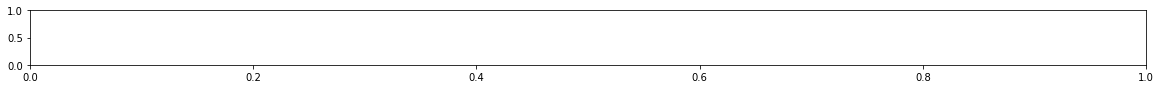

In [18]:
# Define X coords to plot over
X = np.linspace(0,35,2000)

# calculate Y coords for each mixture with Gaussian function
Y= [np.multiply(mix_coeffs_best[i],Gaussian(X, mu, sigma)) for i,mu in enumerate(mus_best)]

# Sum mixtures
Ysum = np.sum(Y,0)

# y axis scaling variable for plotting aesthetics
ysmall = np.add(np.multiply(y,np.max(Ysum)),np.max(Ysum)*0.25)

# close any open plots
plt.close('all')
f = plt.figure(figsize = (20,1))

# plot each gaussian mixture component
for fit in Y:
    plt.plot(X, fit, linewidth = 1, c = 'k')

# Plot sum of components
plt.plot(X,Ysum, linewidth = 2, c = 'k')

# Plot data poiits
plt.scatter(coords,ysmall, marker = 'o', c = clusters_best, edgecolor = 'None')

# Plot best mus
plot_centers(mus_best,'k',2)

# Pretty up the graph a bit
plt.ylim(0,max(Ysum)+0.5*(max(Ysum)))

plt.show()